# Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
vte = pd.read_csv('New_VTE.csv', index_col=False)
nvte = pd.read_csv('New_NVTE.csv', index_col=False)

In [3]:
vte = vte.iloc[:, 1:]
nvte = nvte.iloc[:, 1:]

In [4]:
# drop diagnossi & admit/type
vte = vte.drop(['DIAGNOSIS', 'ADMISSION_TYPE'], axis=1)
nvte = nvte.drop(['DIAGNOSIS', 'ADMISSION_TYPE'], axis=1)

In [5]:
#change gender into binary number
gender = {'M':1, 'F':0}
vte['GENDER'] = [gender[item] for item in vte['GENDER']]
nvte['GENDER'] = [gender[item] for item in nvte['GENDER']]

# change ethnicity into number
enthnicity = {'WHITE':1, 'BLACK':2, 'HISPANIC OR LATINO':3, 'ASIAN':4, 'MIDDLE EASTERN':4, 'PORTUGUESE':5, 
              'AMERICAN INDIAN/ALASKA NATIVE':6, 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER':7, 'OTHER':0,
              'UNKNOWN/NOT SPECIFIED':0, 'UNABLE TO OBTAIN':0, 'PATIENT DECLINED TO ANSWER':0, 'MULTI RACE ETHNICITY':0
             }
vte['ETHNICITY'] = [enthnicity[item] for item in vte['ETHNICITY']]
nvte['ETHNICITY'] = [enthnicity[item] for item in nvte['ETHNICITY']]

# change insurance into binary
insurance = {'Medicaid':1, 'Private':2, 'Medicare': 3, 'Government': 4, 'Self Pay': 5}
vte['INSURANCE'] = [insurance[item] for item in vte['INSURANCE']]
nvte['INSURANCE'] = [insurance[item] for item in nvte['INSURANCE']]

In [6]:
# add target columns for vte and nvte
vte['vte'] = 1
nvte['vte'] = 0

In [7]:
df = pd.concat([vte, nvte]).reset_index(drop=True)

In [8]:
df.head()

,SUBJECT_ID,HADM_ID,INSURANCE,ETHNICITY,GENDER,AGE,ADMIT_TIMES,LENGTH_STAY,READMIT_DAY,001-009,...,94,95,96,97,98,99,chemistry,hematology,blood gas,vte
0,32810,168208,1,1,1,0.000000,0.0,0.029940,0.103448,0,...,0,0,1,0,0,0,1,1,1,1
1,32810,189751,1,1,1,0.000000,0.0,0.215569,0.000000,0,...,0,0,1,0,0,0,1,1,1,1
2,109,124657,1,2,0,0.030769,1.0,0.023952,0.034483,0,...,0,0,0,0,0,0,1,1,0,1
3,109,176760,1,2,0,0.030769,1.0,0.000000,0.034483,0,...,0,0,0,0,0,0,1,1,1,1
4,91469,192145,2,1,1,0.046154,0.0,0.041916,0.344828,0,...,0,0,0,0,0,0,1,1,1,1


In [9]:
df.to_csv('VTE Readmission With 30 Days.csv')

# Split Dataset

In [10]:
X = df.iloc[:, 2:(df.shape[1]-1)]
Y = df.iloc[:, df.shape[1]-1]

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=42)

In [14]:
X_test.shape

(1158, 294)

# Handle Imbalanced Dataset

In [541]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [542]:
X_train_smote, Y_train_smote = smote.fit_sample(X_train,Y_train)

In [543]:
print("Before SMOTE :" , Counter(Y_train))
print("After SMOTE :" , Counter(Y_train_smote))

Before SMOTE : Counter({0: 3339, 1: 133})
After SMOTE : Counter({0: 3339, 1: 3339})


# Balanced Random Forest

In [544]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [545]:
# Create a dict for tuning parameters
brf_para = {}

In [563]:
brf_para['n_estimators'] = [10, 25, 50, 100, 150, 200]
brf_para['max_depth'] = [2,4, 6, 8, 10]
brf_para['min_samples_split'] = [2, 3, 4, 5]
brf_para['min_samples_leaf'] = [15, 20, 25, 30]

## maybe delete

In [564]:
sen_lst=[]
spe_lst=[]
auc_lst=[]
para_lst = []

In [565]:
# Tune the best parameters
for i in brf_para['n_estimators']:
    for j in brf_para['max_depth']:
        for k in brf_para['min_samples_split']:
            for m in brf_para['min_samples_leaf']:
                model = BalancedRandomForestClassifier(n_estimators=i, max_depth=j, 
                                                       max_features='log2',
                                                       min_samples_split=k,
                                                       min_samples_leaf=m,
                                                       random_state=1,
                                                       n_jobs = -1)
                model.fit(X_train, Y_train)
                y_pred = model.predict(X_train)
                tn, fp, fn, tp = metrics.confusion_matrix(Y_train, y_pred).ravel()
                sensitivity = tp/(tp+fn)
                specificity = tn/(fp+tn)
                fpr, tpr, thresholds = metrics.roc_curve(Y_train, y_pred)
                auc = metrics.auc(fpr, tpr)
                if sensitivity <= 0.95:
                    sen_lst.append(sensitivity)
                    spe_lst.append(specificity)
                    auc_lst.append(auc)
                    para_lst.append([i, j, k, m])

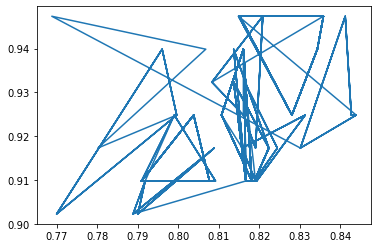

In [566]:
plt.plot(spe_lst, sen_lst)
plt.show()

In [567]:
brf_auc_max = max(auc_lst)
brf_max_index = auc_lst.index(brf_auc_max)

In [572]:
spe_lst[brf_max_index]

0.8412698412698413

In [573]:
para_lst[brf_max_index]

[50, 2, 2, 20]

In [849]:
# Train data
brf = BalancedRandomForestClassifier(n_estimators=50, max_depth=2, 
                                                       max_features='log2',
                                                       min_samples_split=2,
                                                       min_samples_leaf=20,
                                                       random_state=1,
                                                       n_jobs = -1)

In [850]:
brf.fit(X_train, Y_train)
y_train_pred_brf = brf.predict(X_train)

In [365]:
#auc_lst

In [851]:
# Output the sensitivity and specificity for train set
tn, fp, fn, tp = metrics.confusion_matrix(Y_train, y_train_pred_brf).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
print('Trainning Sensitivity: ', sensitivity)
print('Trainning Specificity: ', specificity)

Trainning Sensitivity:  0.9473684210526315
Trainning Specificity:  0.8412698412698413


In [852]:
# Output the auc score for train set
fpr1, tpr1, thresholds1 = metrics.roc_curve(Y_train, y_train_pred_brf)
auc_score1 = metrics.auc(fpr1, tpr1)
print('Trainning AUC: ', auc_score1)

Trainning AUC:  0.8943191311612364


In [853]:
# output confusion matrix for train set
tn, fp, fn, tp

(2809, 530, 7, 126)

In [854]:
# Test model and output sensitivity and specificity
y_test_pred_brf = brf.predict(X_test)

tn11, fp11, fn11, tp11 = metrics.confusion_matrix(Y_test, y_test_pred_brf).ravel()
sensitivity11 = tp11/(tp11+fn11)
specificity11 = tn11/(fp11+tn11)
print('Testing Sensitivity: ', sensitivity11)
print('Testing Specificity: ', specificity11)

Testing Sensitivity:  0.9245283018867925
Testing Specificity:  0.8108597285067873


In [855]:
# Output the auc score for test set
fpr11, tpr11, thresholds11 = metrics.roc_curve(Y_test, y_test_pred_brf)
auc_score11 = metrics.auc(fpr11, tpr11)
print('Testing AUC: ', auc_score11)

Testing AUC:  0.8676940151967899


In [856]:
# output confusion matrix for test set
tn11, fp11, fn11, tp11

(896, 209, 4, 49)

# Support Vector Machines

In [104]:
from sklearn.svm import SVC

In [632]:
# Create a dict for tuning parameters
svm_para = {}

In [857]:
svm_para['kernel'] = ['rbf', 'poly', 'sigmoid', 'linear']
svm_para['C'] = [0.1, 1, 10, 100, 1000]
svm_para['gamma'] = [1, 0.1, 0.01, 0.001, 0.0001]
svm_para['class_weight'] = [{0:1, 1:25}, {0:1, 1:50}, {0:1, 1:100}, {0:1, 1:150}]

In [858]:
# GridSearch
svm = SVC(random_state=1)
gsc_svm = GridSearchCV(svm, svm_para, scoring='roc_auc', n_jobs=-1, cv=5)

In [860]:
#gsc_svm.fit(X_train, Y_train)

In [861]:
#gsc_svm.best_params_

In [977]:
# Train the model with best parameters and predict
svm_model = SVC(C=100, kernel = 'rbf', gamma = 0.0001, random_state=1) #class_weight={1: 30})
svm_model.fit(X_train_smote, Y_train_smote)
y_train_pred_svm = svm_model.predict(X_train_smote)

In [978]:
# Output the sensitivity and specificity
tn2, fp2, fn2, tp2 = metrics.confusion_matrix(Y_train_smote, y_train_pred_svm).ravel()
sensitivity_svm = tp2/(tp2+fn2)
specificity_svm = tn2/(fp2+tn2)
print('Trainning Sensitivity: ', sensitivity_svm)
print('Trainning Specificity: ', specificity_svm)

Trainning Sensitivity:  0.9868224019167415
Trainning Specificity:  0.9281221922731356


In [979]:
# Output the auc score
fpr2, tpr2, thresholds2 = metrics.roc_curve(Y_train_smote, y_train_pred_svm)
auc_score2 = metrics.auc(fpr2, tpr2)
print('Trainning AUC: ', auc_score2)

Trainning AUC:  0.9574722970949385


In [980]:
# output confusion matrix for train set
confusion_matrix(Y_train_smote, y_train_pred_svm)

array([[3099,  240],
       [  44, 3295]])

In [981]:
# Test model and output sensitivity and specificity
y_test_pred_svm = svm_model.predict(X_test)

tn22, fp22, fn22, tp22 = metrics.confusion_matrix(Y_test, y_test_pred_svm).ravel()
sensitivity_svm2 = tp22/(tp22+fn22)
specificity_svm2 = tn22/(fp22+tn22)
print('Testing Sensitivity: ', sensitivity_svm2)
print('Testing Specificity: ', specificity_svm2)

Testing Sensitivity:  0.5471698113207547
Testing Specificity:  0.9140271493212669


In [982]:
# Output the auc score for test set
fpr22, tpr22, thresholds22 = metrics.roc_curve(Y_test, y_test_pred_svm)
auc_score22 = metrics.auc(fpr22, tpr22)
print('Testing AUC: ', auc_score22)

Testing AUC:  0.7305984803210108


In [983]:
# output confusion matrix for test set
tn22, fp22, fn22, tp22

(1010, 95, 24, 29)

# Logistic Regression

In [133]:
from sklearn.linear_model import LogisticRegression

In [606]:
# Create a dict for tuning parameters
lg_para = {'C':[3, 5, 10, 15, 20, 25, 28, 30], 'penalty': ['l1', 'l2'], 'class_weight': [{0:1, 1:25}, {0:1, 1:50}, {0:1, 1:100}, {0:1, 1:150}]}

In [607]:
# GridSearch

lgs = LogisticRegression(max_iter = 1000000, solver = 'liblinear', random_state=1)
gsc_lg = GridSearchCV(lgs, lg_para, scoring='roc_auc_ovr', n_jobs=-1)

In [608]:
gsc_lg.fit(X_train, Y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000000, random_state=1,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [3, 5, 10, 15, 20, 25, 28, 30],
                         'class_weight': [{0: 1, 1: 25}, {0: 1, 1: 50},
                                          {0: 1, 1: 100}, {0: 1, 1: 150}],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc_ovr')

In [609]:
gsc_lg.best_params_

{'C': 3, 'class_weight': {0: 1, 1: 25}, 'penalty': 'l1'}

In [954]:
# Train the model with best parameters and predict
lg = LogisticRegression(C = 10, penalty = 'l2', max_iter = 1000000, solver = 'liblinear', random_state=1)# class_weight = {0:1, 1:25})
lg.fit(X_train_smote, Y_train_smote)
y_train_pred_lg = lg.predict(X_train_smote)

In [955]:
# Output the sensitivity and specificity
tn3, fp3, fn3, tp3 = metrics.confusion_matrix(Y_train_smote, y_train_pred_lg).ravel()
sensitivity_lg = tp3/(tp3+fn3)
specificity_lg = tn3/(fp3+tn3)
print('Trainning Sensitivity: ', sensitivity_lg)
print('Trainning Specificity: ', specificity_lg)

Trainning Sensitivity:  0.9826295297993412
Trainning Specificity:  0.9649595687331537


In [984]:
# Output the auc score for train set
fpr3, tpr3, thresholds3 = metrics.roc_curve(Y_train_smote, y_train_pred_lg)
auc_score3 = metrics.auc(fpr3, tpr3)
print('Trainning AUC: ', auc_score3)

Trainning AUC:  0.9737945492662473


In [958]:
# output confusion matrix for train test
tn3, fp3, fn3, tp3

(3222, 117, 58, 3281)

In [959]:
# Test model and output sensitivity and specificity
y_test_pred_lg = lg.predict(X_test)

tn33, fp33, fn33, tp33 = metrics.confusion_matrix(Y_test, y_test_pred_lg).ravel()
sensitivity_lg3 = tp33/(tp33+fn33)
specificity_lg3 = tn33/(fp33+tn33)
print('Testing Sensitivity: ', sensitivity_lg3)
print('Testing Specificity: ', specificity_lg3)

Testing Sensitivity:  0.41509433962264153
Testing Specificity:  0.9475113122171945


In [960]:
# Output the auc score for test set
fpr33, tpr33, thresholds33 = metrics.roc_curve(Y_test, y_test_pred_lg)
auc_score33 = metrics.auc(fpr33, tpr33)
print('Testing AUC: ', auc_score33)

Testing AUC:  0.681302825919918


In [961]:
# output confusion matrix for test set
tn33, fp33, fn33, tp33

(1047, 58, 31, 22)

# XGBoost

In [650]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from sklearn.datasets import make_classification

#### Tune learning rate

In [693]:
# define grid
xgb_para = {'learning_rate': [0.1, 0.25, 0.4, 0.5],
           'n_estimators':[50, 100, 150, 200]}

# define model
xgb = XGBClassifier(max_depth = 5, min_child_weight = 1, gamma = 0.1, subsample = 0.8, colsample_bytree = 0.8,
                    random_state=1, objective= 'binary:logistic', use_label_encoder =False, scale_pos_weight = 25)
gsc_xgb = GridSearchCV(xgb, xgb_para, scoring='roc_auc', n_jobs=-1, cv=5)

In [694]:
gsc_xgb.fit(X_train, Y_train, eval_metric='rmse')

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0.1,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=25,
      

In [695]:
gsc_xgb.best_params_

{'learning_rate': 0.1, 'n_estimators': 200}

#### Tune max_depth and min_child_weight

In [703]:
xgb_para1 = {'max_depth': [1,2,3],
            'min_child_weight': [5, 6, 7]}

xgb1 = XGBClassifier(learning_rate = 0.1, n_estimators = 200, gamma = 0.1, subsample = 0.8, colsample_bytree = 0.8,
                    random_state=1, objective= 'binary:logistic', use_label_encoder =False, scale_pos_weight = 25)
gsc_xgb1 = GridSearchCV(xgb1, xgb_para1, scoring='roc_auc', n_jobs=-1, cv=5)

In [704]:
gsc_xgb1.fit(X_train, Y_train, eval_metric='rmse')

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0.1,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=25,
 

In [705]:
gsc_xgb1.best_params_

{'max_depth': 3, 'min_child_weight': 6}

In [700]:
gsc_xgb1.best_score_

0.9803258914838604

#### Tune gamma

In [709]:
xgb_para2 = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5]}

xgb2 = XGBClassifier(learning_rate = 0.1, n_estimators = 200, max_depth = 3,
                     min_child_weight = 6, subsample = 0.8, colsample_bytree = 0.8,
                    random_state=1, objective= 'binary:logistic', use_label_encoder =False, scale_pos_weight = 25)
gsc_xgb2 = GridSearchCV(xgb2, xgb_para2, scoring='roc_auc', n_jobs=-1, cv=5)

In [710]:
gsc_xgb2.fit(X_train, Y_train, eval_metric='rmse')

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=25,
      

In [711]:
gsc_xgb2.best_params_

{'gamma': 0.1}

In [814]:
# Train the model with best parameters and predict
xgb_best = XGBClassifier(learning_rate = 0.003, n_estimators = 100, max_depth = 3,
                     min_child_weight = 30, subsample = 0.5, colsample_bytree = 0.5,
                    random_state=1, objective= 'binary:logistic', use_label_encoder =False, gamma = 0.1, 
                         scale_pos_weight = 20)

In [815]:
xgb_best.fit(X_train, Y_train, eval_metric='rmse')
y_train_pred_xgb = xgb_best.predict(X_train)

In [816]:
# Output the sensitivity and specificity
tn4, fp4, fn4, tp4 = metrics.confusion_matrix(Y_train, y_train_pred_xgb).ravel()
sensitivity_xgb = tp4/(tp4+fn4)
specificity_xgb = tn4/(fp4+tn4)
print('Trainning Sensitivity: ', sensitivity_xgb)
print('Trainning Specificity: ', specificity_xgb)

# Output the auc score for train set
fpr4, tpr4, thresholds4 = metrics.roc_curve(Y_train, y_train_pred_xgb)
auc_score4 = metrics.auc(fpr4, tpr4)
print('Trainning AUC: ', auc_score4)

Trainning Sensitivity:  0.9548872180451128
Trainning Specificity:  0.8828990715783168
Trainning AUC:  0.9188931448117148


In [817]:
# output confusion matrix
metrics.confusion_matrix(Y_train, y_train_pred_xgb)

array([[2948,  391],
       [   6,  127]])

In [818]:
# Test model and output sensitivity and specificity
y_test_pred_xgb = xgb_best.predict(X_test)

tn44, fp44, fn44, tp44 = metrics.confusion_matrix(Y_test, y_test_pred_xgb).ravel()
sensitivity_xgb44 = tp44/(tp44+fn44)
specificity_xgb44 = tn44/(fp44+tn44)
print('Testing Sensitivity: ', sensitivity_xgb44)
print('Testing Specificity: ', specificity_xgb44)

# Output the auc score for test set
fpr44, tpr44, thresholds44 = metrics.roc_curve(Y_test, y_test_pred_xgb)
auc_score44 = metrics.auc(fpr44, tpr44)
print('Testing AUC: ', auc_score44)

Testing Sensitivity:  0.9245283018867925
Testing Specificity:  0.8723981900452489
Testing AUC:  0.8984632459660207


In [819]:
confusion_matrix(Y_test, y_test_pred_xgb)

array([[964, 141],
       [  4,  49]])

# Find Top 10 Significant Features In Model

In [985]:
from xgboost import plot_importance

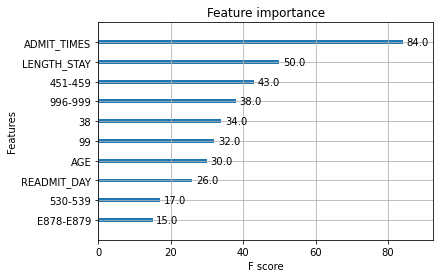

In [986]:
plot_importance(xgb_best, max_num_features=10)
plt.show()

In [991]:
print('10 most revelent factors: \nAdmit Times\nLength_Stay\nDiseases Of Veins And Lymphatics, And Other Diseases Of Circulatory System\nComplications Of Surgical And Medical Care, Not Elsewhere Classified\nIncision, Excision, And Occlusion Of Vessels\nOther Nonoperative Procedures\nAge\nReadmit Day\nDiseases Of Esophagus, Stomach, And Duodenum\nSurgical And Medical Procedures As The Cause Of Abnormal Reaction Of Patient Or Later Complication, Without Mention Of Misadventure At The Time Of Procedure')

10 most revelent factors: 
Admit Times
Length_Stay
Diseases Of Veins And Lymphatics, And Other Diseases Of Circulatory System
Complications Of Surgical And Medical Care, Not Elsewhere Classified
Incision, Excision, And Occlusion Of Vessels
Other Nonoperative Procedures
Age
Readmit Day
Diseases Of Esophagus, Stomach, And Duodenum
Surgical And Medical Procedures As The Cause Of Abnormal Reaction Of Patient Or Later Complication, Without Mention Of Misadventure At The Time Of Procedure


# Save the models

In [47]:
from joblib import dump, load

In [52]:
dump(lg, 'LogisticRegression.jlib')

['LogisticRegression.jlib']

In [49]:
model = load('BalancedRandomForest.jlib')